# Sheet 1 - McCulloch–Pitts Neurons and Perceptron Learning

## Instaling and Importing Required Packages

In [1]:
!pip install numpy
!pip install matplotlib

In [2]:
import numpy as np

from numpy.typing import NDArray
from typing import Final, Any, TypeAlias

import itertools

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from collections.abc import Sequence

In [3]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 300

RNG: Final[np.random.Generator] = np.random.default_rng(42)

## Exercise 1 - McCulloch–Pitts Neuron

In [4]:
class Perceptron:

    def __init__(self, input_size: int, rng: np.random.Generator = RNG) -> None:
        k: np.float64 = np.sqrt(1 / input_size)
        self.w: NDArray[np.float64] = rng.uniform(-k, k, size=input_size)

    def __call__(self, x: NDArray[np.float64]) -> np.float64:
        return np.sign(self.w @ x)

    def fit(
        self, xs: NDArray[np.float64], ys: NDArray[np.float64], learning_rate: float, max_epochs: int = 1000
    ) -> int:
        for epoch in range(1, max_epochs + 1):
            previous_weights: NDArray[np.float64] = self.w.copy()

            # Update weights
            for x, y in zip(xs, ys, strict=True):
                self.w += learning_rate * (y - self(x)) * x

            # Check for convergence
            if np.allclose(previous_weights, self.w):
                return epoch

        raise RuntimeError(f"Exceeded maximum number of epochs ({max_epochs!r}) without convergence.")

In [5]:
perceptron: Perceptron = Perceptron(input_size=3)
perceptron.w = np.array([3, 2, 2], dtype=np.float64)

print("x1  x2   y")
for x1, x2 in itertools.product([-1, 1], repeat=2):
    prediction: np.float64 = perceptron(
        np.array([-1, x1, x2], dtype=np.float64)
    ).astype(np.int64)
    print(f"{x1:>2}  {x2:>2}  {prediction:>2}")

x1  x2   y
-1  -1  -1
-1   1  -1
 1  -1  -1
 1   1   1


# Exercise 2 - Activation Functions

In [6]:
def sigmoid(x: NDArray[np.float64], a: np.float64 | float) -> NDArray[np.float64]:
    return 2 / (1 + np.exp(-a * x))

In [7]:
def tanh(x: NDArray[np.float64], a: np.float64 | float) -> NDArray[np.float64]:
    return np.tanh(a * x)

In [8]:
def piecewise_linear(
    x: NDArray[np.float64], a: np.float64 | float
) -> NDArray[np.float64]:
    return np.piecewise(
        x,
        [x >= 1 / a, np.logical_and(-1 / a < x, x < 1 / a), x <= -1 / a],
        [1, lambda x: a * x, -1],
    )

In [9]:
def plot_activation(activation: Any, a_choices: tuple[int, ...] = (0.5, 1, 5)) -> None:
    x: NDArray[np.float64] = np.linspace(-5, 5, 100, dtype=np.float64)

    _, ax = plt.subplots()
    for a in a_choices:
        ax.plot(x, activation(x, a), label=f"{activation.__name__} {a=}")

    ax.legend(loc="upper left")
    ax.set_xlabel("x")
    ax.set_ylabel("y(x)")

    ax.margins(x=0)

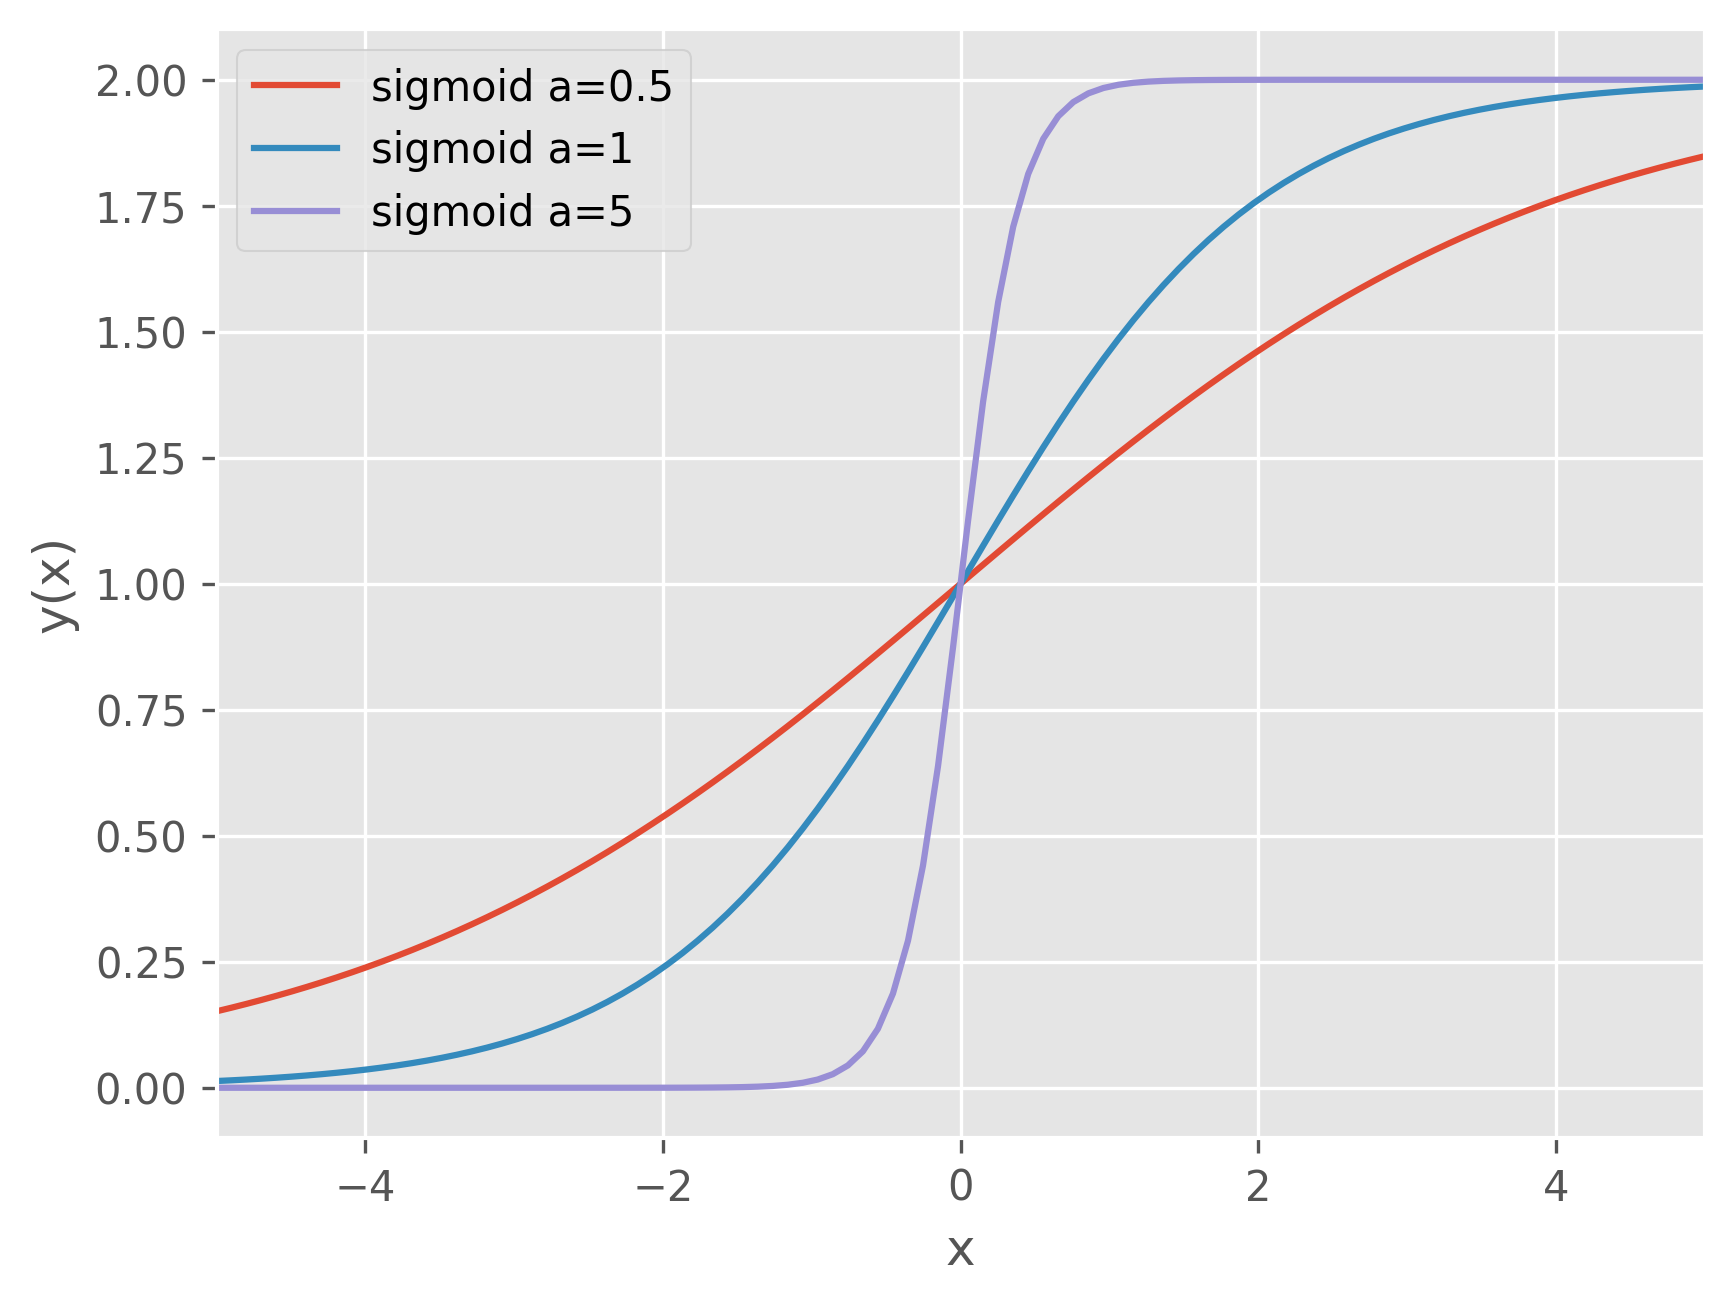

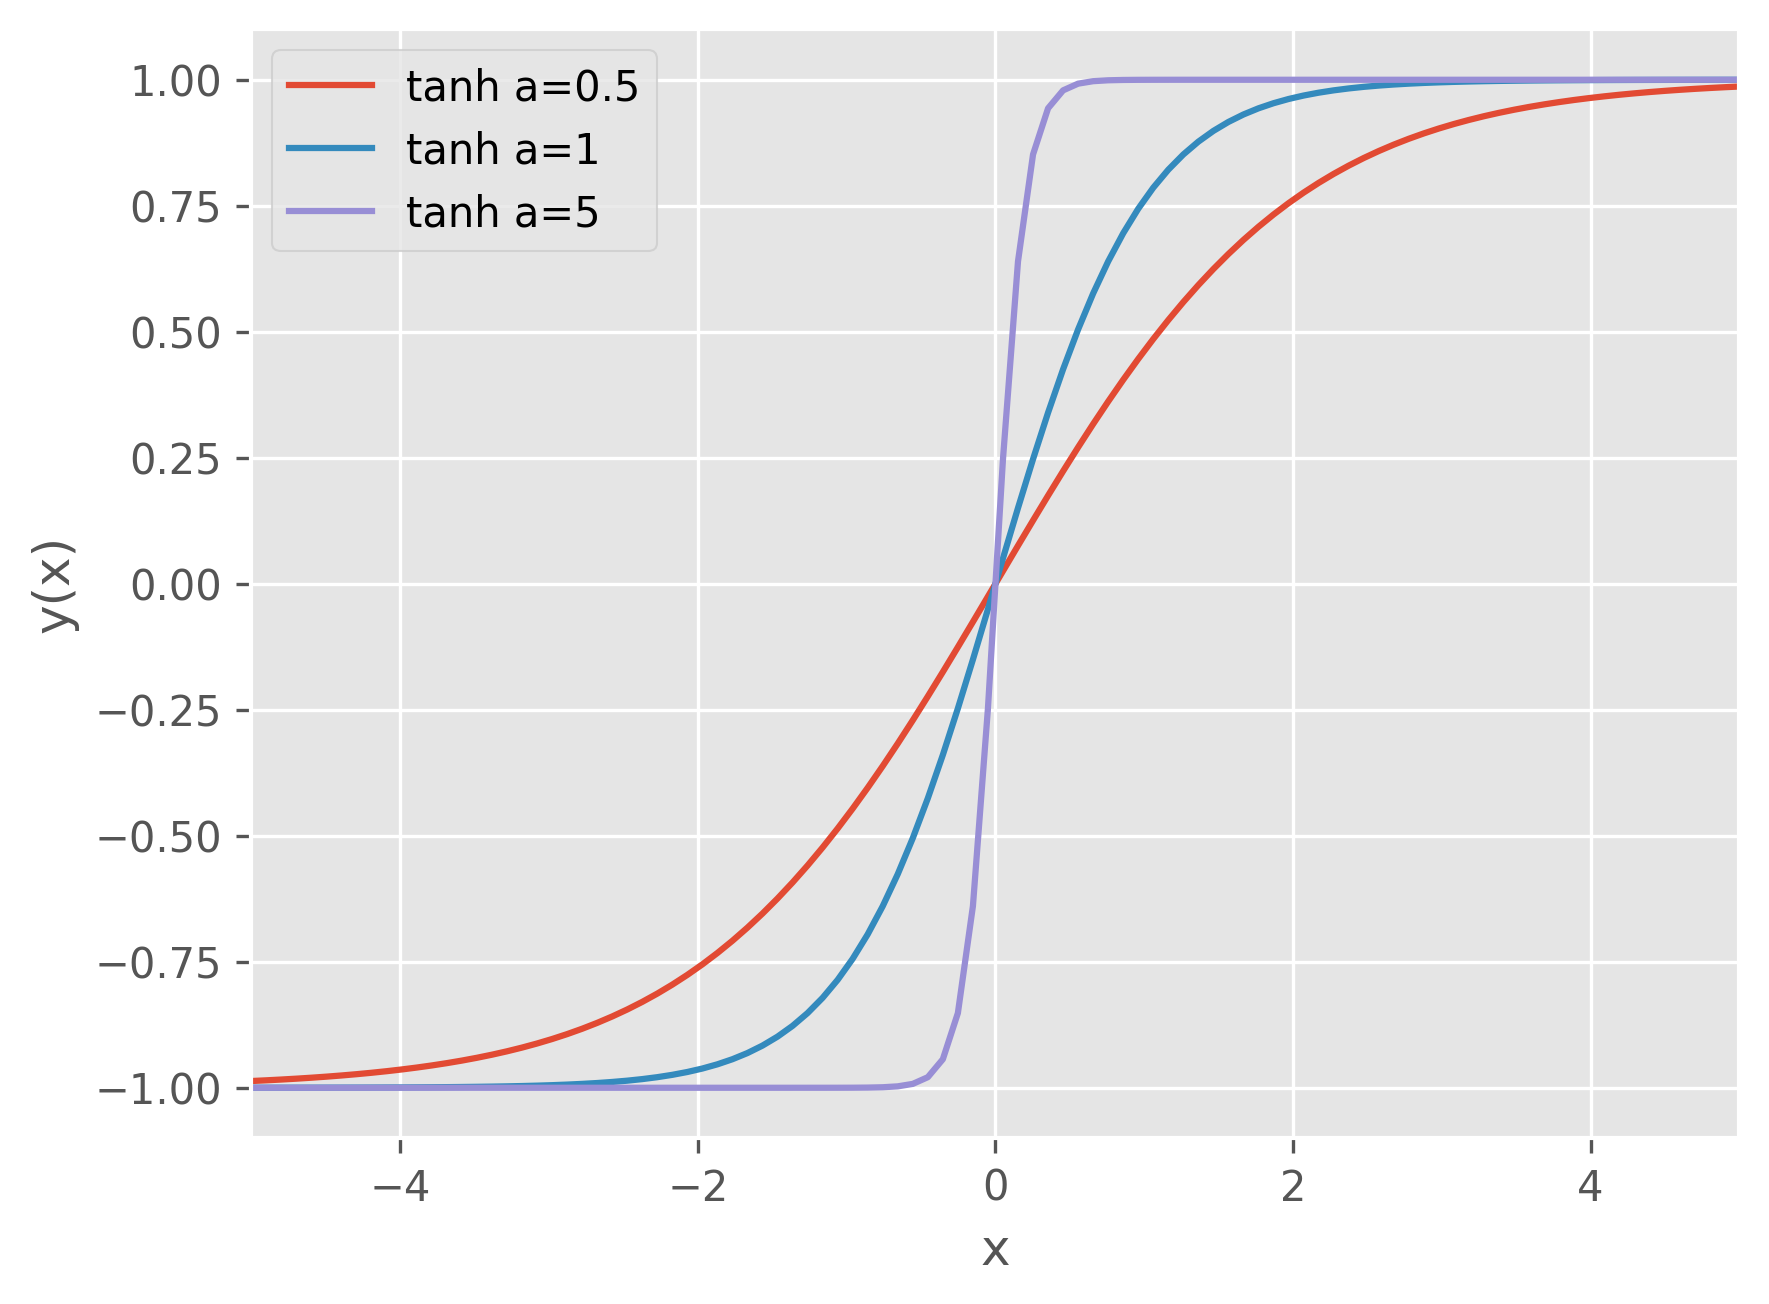

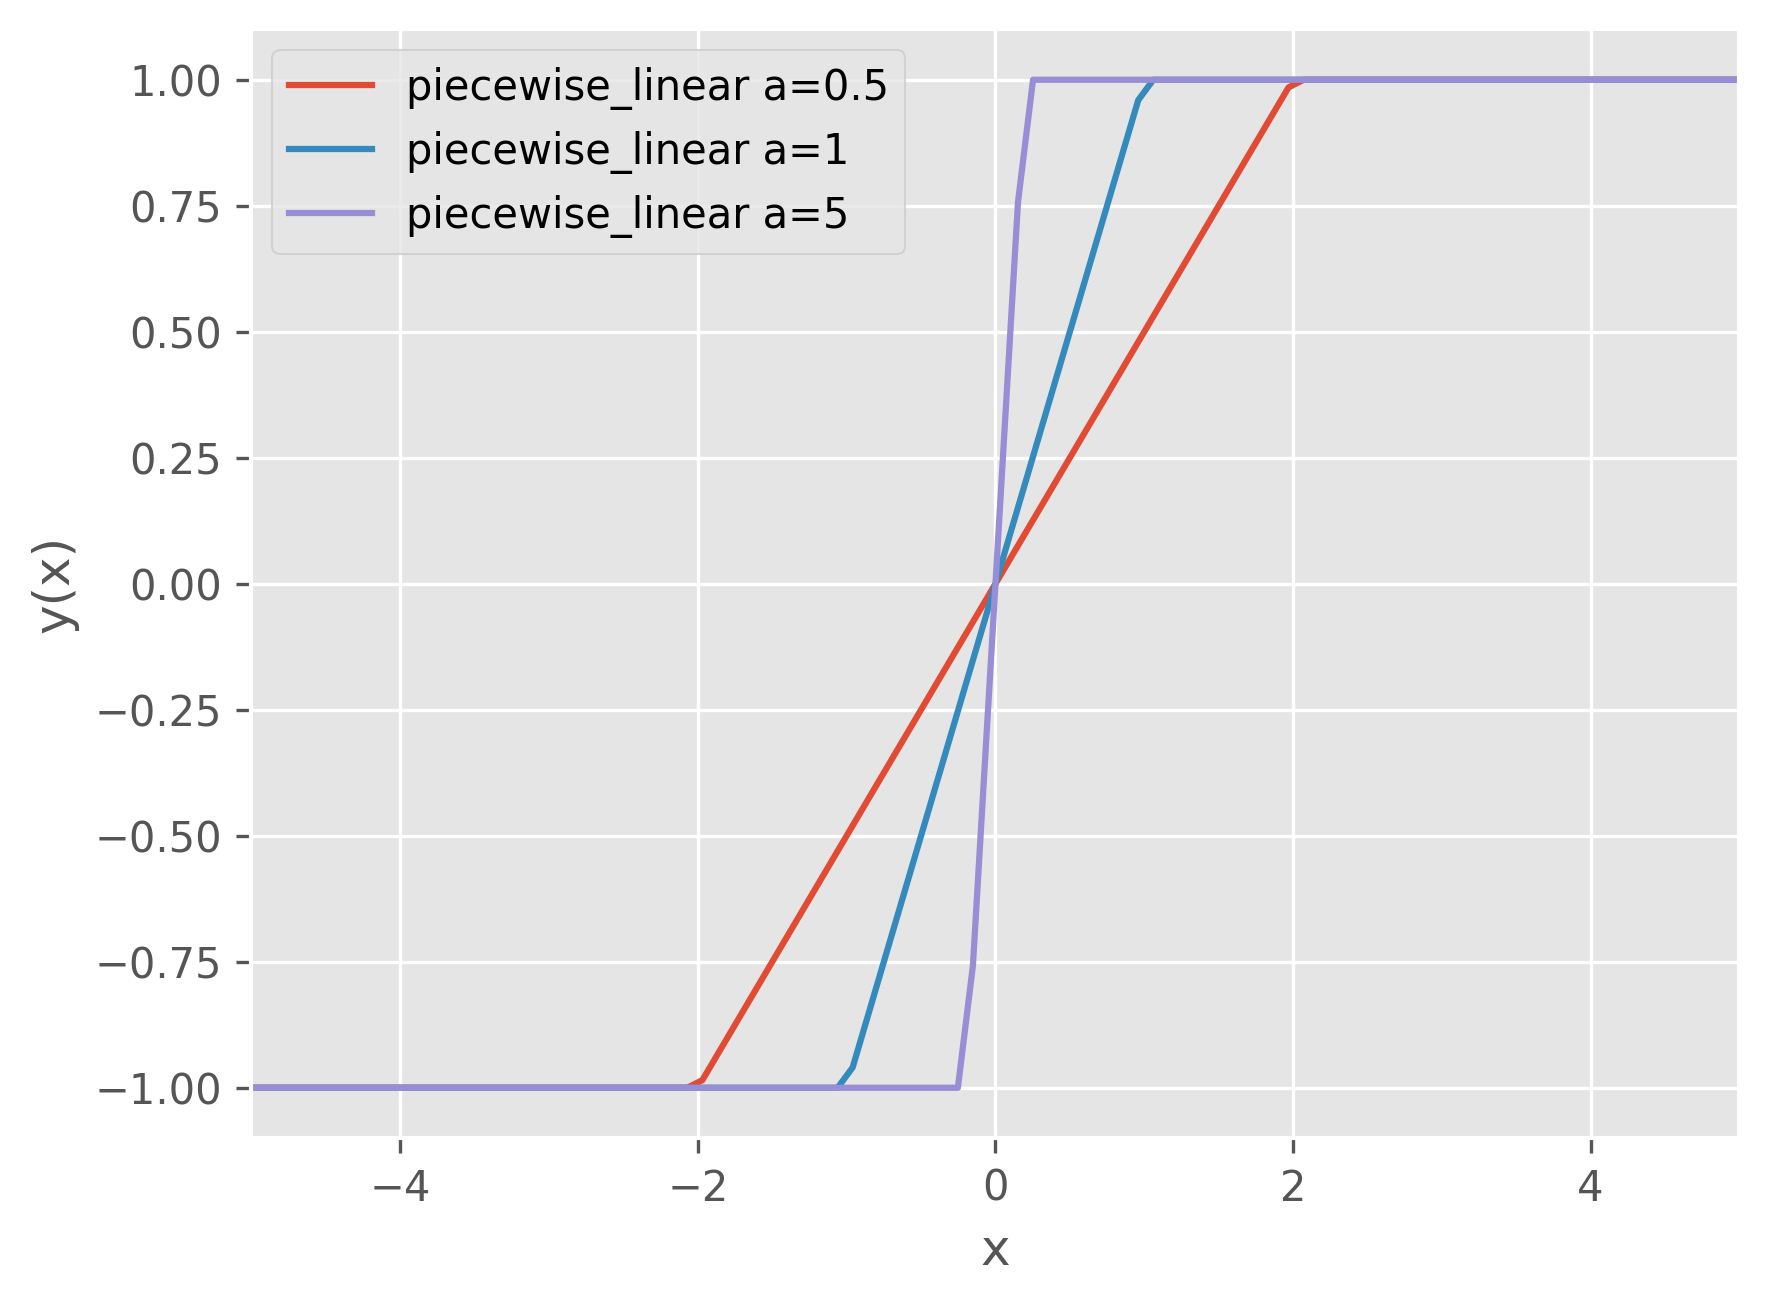

In [10]:
plot_activation(sigmoid)
plot_activation(tanh)
plot_activation(piecewise_linear)

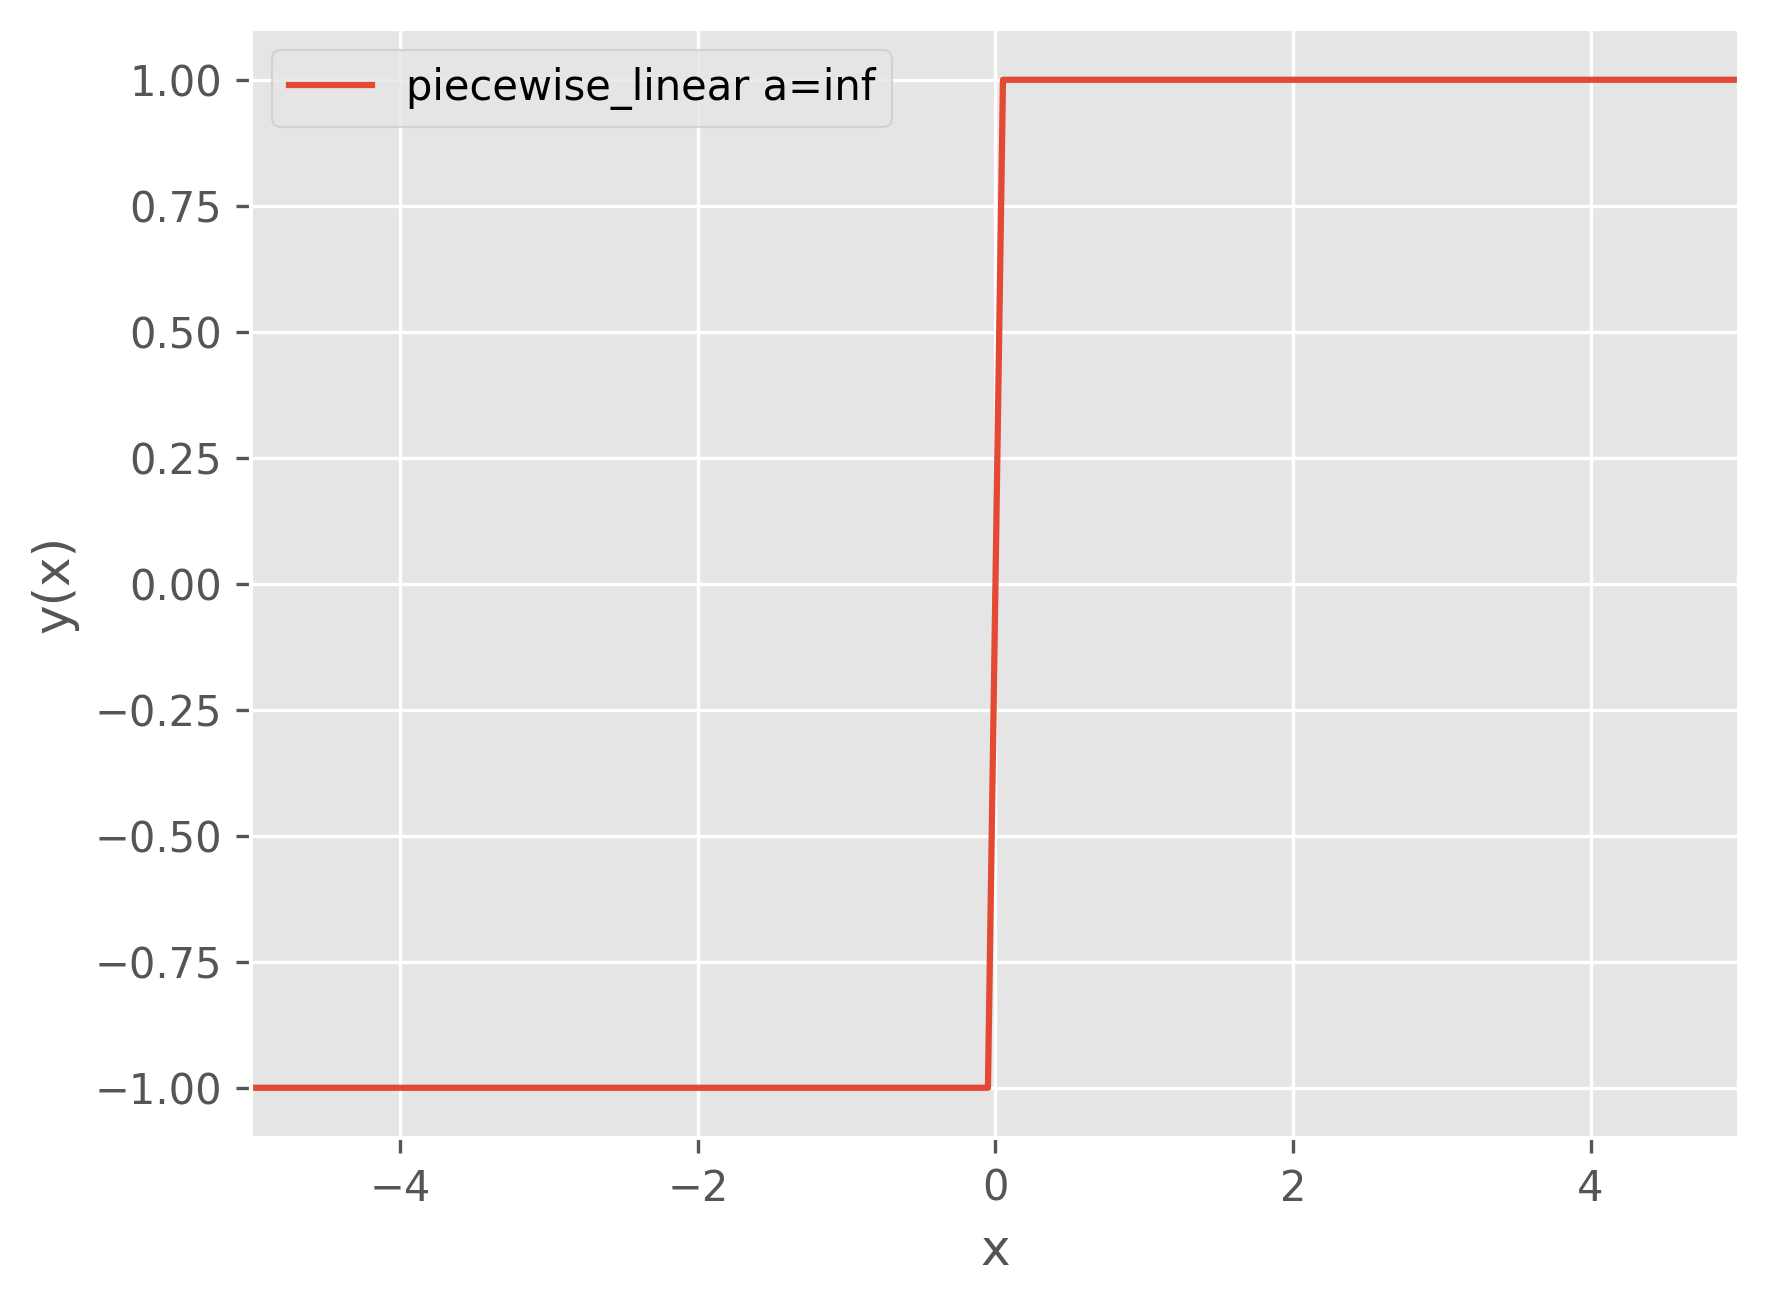

In [11]:
plot_activation(piecewise_linear, a_choices=(np.inf,))

# Exercise 3 - Rosenblatt's Perceptron

In [12]:
Dataset: TypeAlias = tuple[NDArray[np.float64], NDArray[np.float64]]

def generate_dataset(n: int, rng: np.random.Generator = RNG) -> Dataset:
    xs: NDArray[np.float64] = np.concatenate(
        (
            np.full(shape=(n, 1), fill_value=-1.0, dtype=np.float64),
            rng.normal(size=(n, 2)),
        ),
        axis=1,
    )

    difference: NDArray[np.float64] = xs[:, 1] - xs[:, 2]
    ys: NDArray[np.float64] = np.piecewise(
        difference,
        [difference >= 0.5, difference < 0.5],
        [1, -1],
    )

    return xs, ys

In [18]:
training_dataset: Dataset = generate_dataset(n=1000)
perceptron = Perceptron(input_size=3)
convergence_epoch: int = perceptron.fit(*training_dataset, learning_rate=0.1)
print(f"Convergerd after {convergence_epoch} epochs")

Convergerd after 34 epochs


We use a learning rate $0 < \eta\ll 1$ to ensure a stable learning process until convergence. A smaller (but appropriate) learning rate ensures the update rule does not overshoot an optimum. Nevertheless, in this simple task, a larger learning rate, e.g. 5, leads to convergence as well. The learning rate still needs to be positive since a negative learning rate would reverse the direction of the weight updates, thus increasing the training error rather than decreasing it.

TODO: Is this biologically possible?

In [22]:
validation_dataset = generate_dataset(n=1000)

all_correct: bool = True
for x, y_true in zip(*validation_dataset):
    prediction: np.float64 = perceptron(x)

    if prediction != y_true:
        all_correct = False
        print(
            f"Prediction mismatch: x={x}, y_true={y_true.item()}, prediction={prediction.item()}"
        )

if all_correct:
    print("All inputs have been classified correctly.")

All inputs have been classified correctly.


In [33]:
def plot_data_points_2d(ax: Axes, xs: NDArray[np.float64], ys: NDArray[np.float64], **kwargs: Any) -> None:
    assert xs.shape[1] == 2, "xs must be 2D data"

    x1s: NDArray[np.float64] = xs[:, 0]
    x2s: NDArray[np.float64] = xs[:, 1]

    ax.scatter(x1s[ys == -1], x2s[ys == -1], label="Negative", **kwargs)
    ax.scatter(x1s[ys ==6 1], x2s[ys == 1], label="Positive", **kwargs)

    ax.set_xlabel("$x_{1}$")
    ax.set_ylabel("$x_{2}$")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3239516416.py, line 8)

In [42]:
def plot_decision_boundary_2d(ax: Axes, w: NDArray[np.float64]) -> None:
    assert w.shape == (3, )
    
    intercept = (0, w[0] / w[2])
    ax.axline(
        xy1=intercept,
        slope=-w[1] / w[2],
        label="$w^{T}x=0$",
        color="navy",
        alpha=0.7,
    )

    ax.quiver(
        *intercept,
        *w[1:],
        # angles="xy",
        scale_units="xy",
        scale=1,
        width=0.0025,
    )

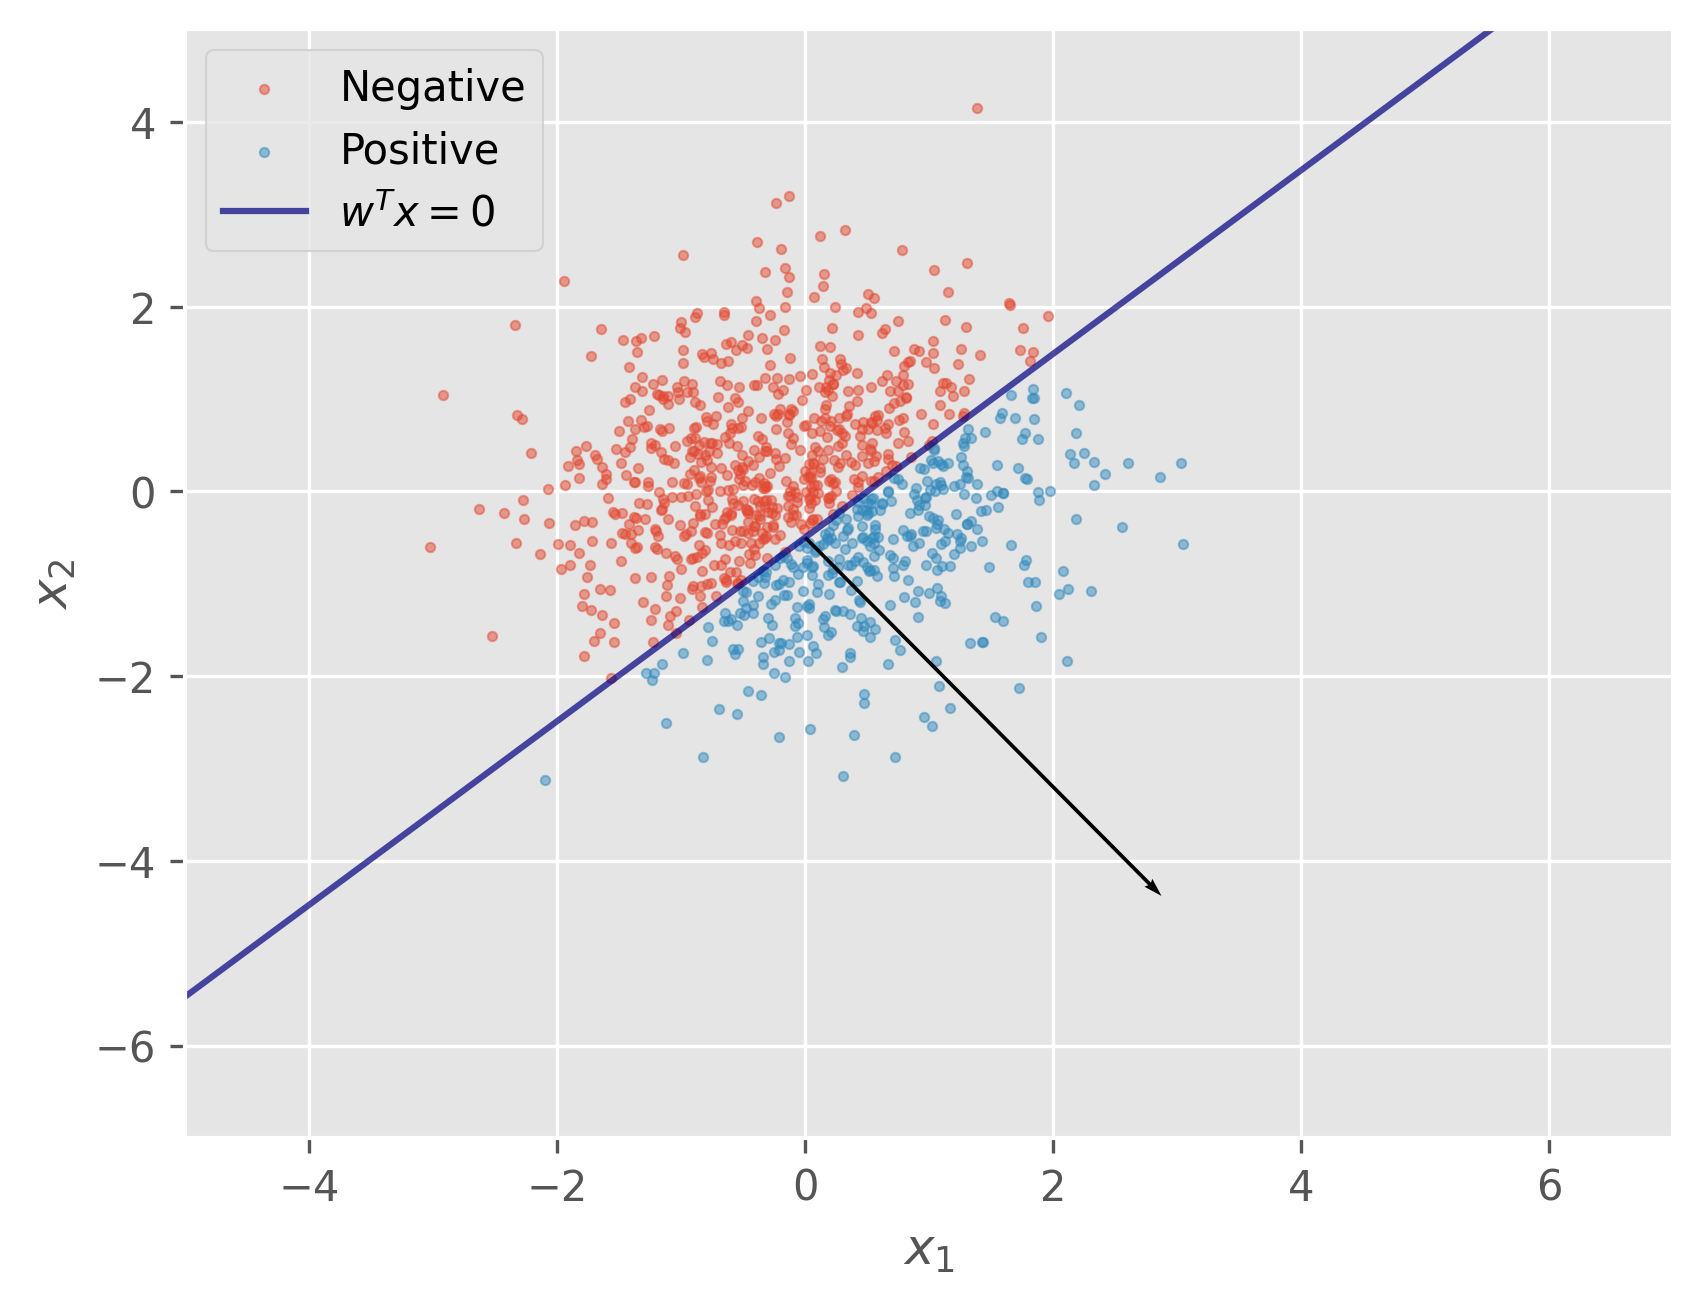

In [43]:
_, ax = plt.subplots()

plot_data_points_2d(ax, xs=training_dataset[0][:,1:], ys=training_dataset[1], s=5, alpha=0.5)
plot_decision_boundary_2d(ax, w=perceptron.w)

ax.set_xlim(-5, 7)
ax.set_ylim(-7, 5)

ax.legend(loc="upper left")

The weight vector $w$ is near-optimal in the sense of its direction. Nevertheless, it is suboptimal in the sense of its magnitude since there is no normalization constraint enforced during or after the training. Therefore, the weight vector's magnitude gets increasingly large.

TODO: Why generalization of the AND operation?

## Exercise 4 - Linear Separability

In [45]:
def generate_xor_dataset(n: int, rng: np.random.Generator = RNG) -> Dataset:
    xs: NDArray[np.float64] = np.concatenate(
        (
            np.full(shape=(n, 1), fill_value=-1.0, dtype=np.float64),
            rng.normal(size=(n, 2)),
        ),
        axis=1,
    )

    ys: NDArray[np.float64] = ((xs[:, 1] > 0) != (xs[:, 2] > 0)).astype(np.float64)
    ys[ys == 0] = -1

    return xs, ys

In [46]:
soft_xor_xs, soft_xor_ys = generate_xor_dataset(n=1000)

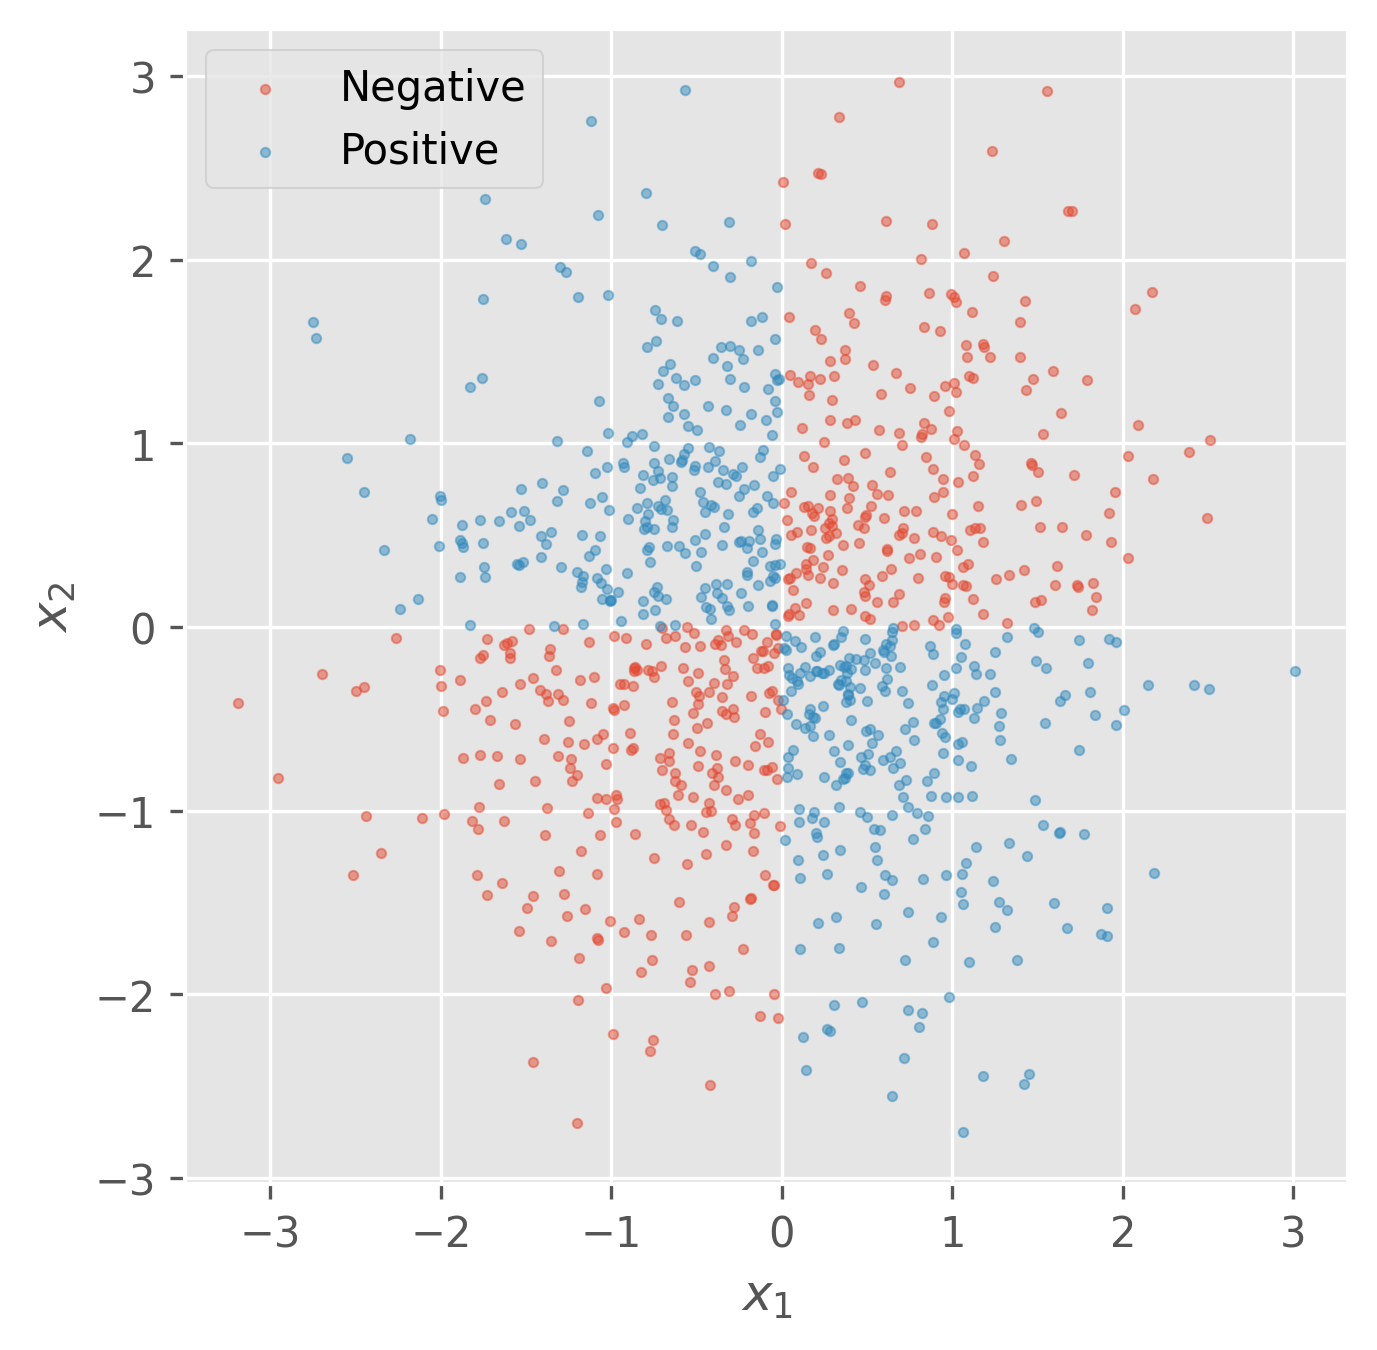

In [47]:
_, ax = plt.subplots(figsize=(5,5))

plot_data_points_2d(ax, xs=soft_xor_xs[:, 1:], ys=soft_xor_ys, s=5, alpha=0.5)
ax.legend(loc="upper left")

In [48]:
xor_perceptron = Perceptron(input_size=3)

max_epochs: int = 1000
try:
    convergence_epoch: int = xor_perceptron.fit(xs=soft_xor_xs, ys=soft_xor_ys, learning_rate=0.1, max_epochs=max_epochs)
    print(f"Convergerd after {convergence_epoch} epochs")
except RuntimeError:
    print(f"No convergence after {max_epochs} epochs")

No convergence after 1000 epochs


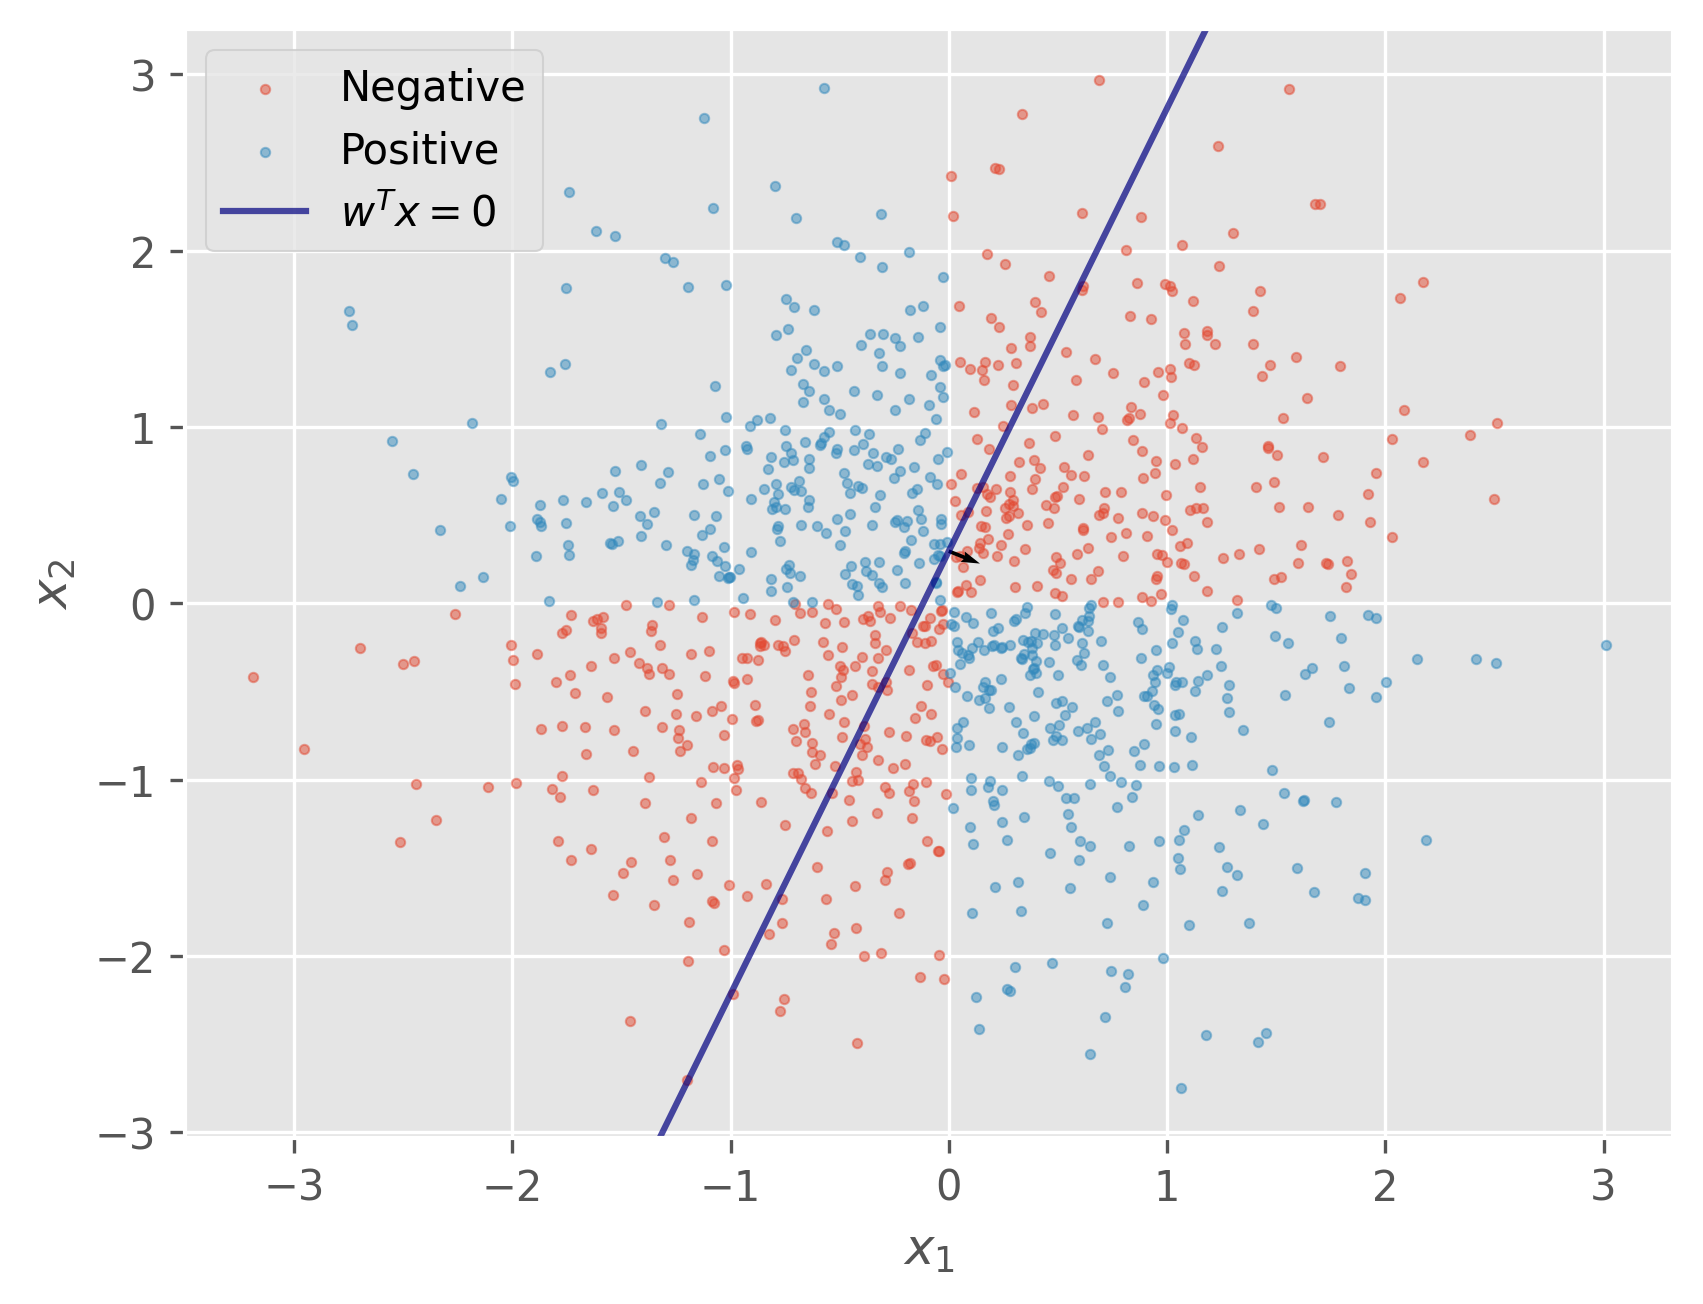

In [49]:
_, ax = plt.subplots()

plot_data_points_2d(ax, xs=soft_xor_xs[:,1:], ys=soft_xor_ys, s=5, alpha=0.5)
plot_decision_boundary_2d(ax, w=xor_perceptron.w)

ax.legend(loc="upper left")

Since XOR is not separable by a linear function, a perceptron that can only fit linear decision boundaries can not learn the XOR function.